In [2]:
# AMDG
import stim
import numpy as np
import itertools
from copy import copy
from copy import deepcopy
from random import random
import sys
import matplotlib.pyplot as plt

todo:

* Bug: Make sure identity error doesn't affect the Bell pair creation
* Build better debug methods for multi-round purification
* Can we actually push measurements to the end?


Interesting result:</br>

In the case where we have multiple rounds of purification, the Fidelity appears to get **worse** with the number of rounds. My hypothesis is that the z-error is poisoning the circuit, since individual z-contributions from all of the input pairs go uncorrected.</br>

This claim is supported by the fact that the fidelity improves when num_rounds = 1. The purification is definitely correcting at each purification step. But doesn't this contradict principle of deferred measurement? Need to investigate this further.

Maybe not. If you're adding exponentially more resource overhead then uncorrectable error is going to compound exponentially. Simplest way to check this is to verify that the circuit corrects x-dephasing noise for the multi-round case.

I think this is where twirling comes into the picture. We want to transform z depolarizing errors into x after each purification block. How do we do this?

### Circuit Construction Methods

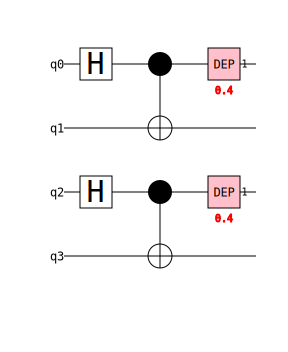

In [228]:
def initialize_pairs(num_qubits, F_err=0.0, bell_error_type="DEPOLARIZE1"):
    circuit = stim.Circuit()
    hadamards = range(num_qubits)[::2]
    cnots = range(num_qubits)
    circuit.append_operation("H", hadamards)
    circuit.append_operation("CNOT", cnots)
    if F_err != 0: circuit.append_operation(bell_error_type, hadamards, F_err)
    return circuit

q = 4
c = initialize_pairs(q, F_err=0.4)
c.diagram(type="timeline-svg")

In [200]:
def add_bilateral_cnots(circuit, pairs, cnot_err=0.0):
    # pairs = (1). a1 a2 b1 b2, (2). a1 a2 b1 b2, ...
    # cnots: (1). b1 a1 b2 a2, (2). b1 a1 b2 a2, ....
    cnots = copy(pairs)
    for twopair in range(len(cnots))[::4]:
        cnots[twopair + 0], cnots[twopair + 2] = cnots[twopair + 2], cnots[twopair + 0] # a1 a2 b1 b2 -> b1 a2 a1 b2
        cnots[twopair + 1], cnots[twopair + 2] = cnots[twopair + 2], cnots[twopair + 1] # b1 a2 a1 b2 -> b1 a1 a2 b2
        cnots[twopair + 2], cnots[twopair + 3] = cnots[twopair + 3], cnots[twopair + 2] # b1 a1 a2 b2 -> b1 a1 b2 a2
    # This is good to return at this point, but additional reordering is makes circuit drawing more compact
    halfA = [i for pair in zip(cnots[::4], cnots[1::4]) for i in pair]
    halfB = [i for pair in zip(cnots[2::4], cnots[3::4]) for i in pair]
    if cnot_err != 0: circuit.append_operation("DEPOLARIZE2", halfA + halfB, cnot_err)
    circuit.append_operation("CNOT", halfA + halfB)
    return

In [4]:
def add_conditional_teleportation(circuit, num_purifiers, cnot_err=0.0):
    num_qubits = circuit.num_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    qubits_to_teleport = [i for i in range(0, num_qubits) if (i+1) % qubits_per_purifier == 0 or (i+2) % qubits_per_purifier == 0]
    halfA = qubits_to_teleport[::2]
    halfB = qubits_to_teleport[1::2]
    targetA = np.ones(len(halfA), int) * (num_qubits)
    targetB = np.ones(len(halfB), int) * (num_qubits + 1)
    cnots = [i for pair in zip(halfA, targetA, halfB, targetB) for i in pair]
    if cnot_err != 0: circuit.append_operation("DEPOLARIZE2", cnots, cnot_err)
    circuit.append_operation("CNOT", cnots)
    return

In [5]:
def add_measurement_resets(circuit, num_purifiers):
    ancilla_qubits = 2
    num_qubits = circuit.num_qubits - ancilla_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    measure_qubits = [i for i in range(0, num_qubits) if (i+1) % qubits_per_purifier != 0 and (i+2) % qubits_per_purifier != 0]
    circuit.append_operation("MR", measure_qubits)
    return circuit

In [6]:
"""
Given a list of measurements for the circuit, return which (if any) purification blocks were successful.
A purification block is successful if all consecutive measurements in that block have the same parity.
"""
def which_purifications_succeeded(simulator, num_purifiers, manual_debug_input = None, debug = False):
    ancilla_qubits = 2
    num_qubits = simulator.num_qubits - ancilla_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    measurements_per_purifier = qubits_per_purifier - ancilla_qubits
    measurements = simulator.current_measurement_record()
    if manual_debug_input != None: 
        measurements = manual_debug_input
    successful_purifications = []
    for pidx in range(num_purifiers):
        measurement_slice = measurements[pidx * measurements_per_purifier : measurements_per_purifier * (pidx + 1)]
        purification_success = all(measurement_slice[i] == measurement_slice[i+1] for i in range(0, len(measurement_slice) - 1, 2))
        if purification_success: successful_purifications.append(pidx)
    if debug == True: 
        print(f"Purification measurements: {measurements}")
        print(f"successful purifications: {successful_purifications}")
    return successful_purifications

In [7]:
"""
Return correction circuit with teleportation measurements
"""
def teleport_with_correction(circuit, simulator, num_purifiers, purifier_successes, single_gate_err=0.0, debug=False):
    
    teleport_circuit = stim.Circuit()
    
    # Custom iterators for later
    def iterate_pairs(lst):
        for i in range(0, len(lst), 2):
            yield lst[i:i+2]
            
    def iterate_two_pairs(lst1, lst2):
        for i in range(0, len(lst1), 2):
            yield (lst1[i:i+2], lst2[i:i+2])
    
    ancilla_qubits = 2
    num_qubits = circuit.num_qubits - ancilla_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    qubits_to_measure = [i for i in range(0, num_qubits) if (i+1) % qubits_per_purifier == 0 or (i+2) % qubits_per_purifier == 0]
    
    purifier = purifier_successes[0] # Choose the first good purifier
    pair_to_teleport = [qubits_to_measure[2 * purifier], qubits_to_measure[2 * purifier + 1]]
    for pair in iterate_pairs(qubits_to_measure):
        if pair == pair_to_teleport:
            teleport_circuit.append("MX", pair)
            teleport_circuit.append("R", pair)
        else:
            teleport_circuit.append("M", pair)
            teleport_circuit.append("R", pair)    
    
    simulator.do(teleport_circuit)
    circuit.__iadd__(teleport_circuit)
    
    # Part 2: Add error correcting gates (NB: Measurement of 0 == True, Measurement of 1 == False)
    correction_circuit = stim.Circuit()
    tf = {True:0, False:1}
    outanc = [num_qubits, num_qubits + 1]
    num_tele_measurements = len(qubits_to_measure)
    tele_measurements = simulator.current_measurement_record()[-num_tele_measurements:]
    if debug == True: 
        print(f"qubits to measure in teleportation step: {qubits_to_measure}")
        print(f"teleportation measurements: {tele_measurements}")
    # Iterate over the last most recent measurements
    for qubit_pair, measurement_pair in iterate_two_pairs(qubits_to_measure, tele_measurements):
        if qubit_pair == pair_to_teleport:
            # Z measurements
            correction_circuit.append("Z", outanc[0]) if measurement_pair[0] else correction_circuit.append("I", outanc[0]);
            correction_circuit.append("Z", outanc[1]) if measurement_pair[1] else correction_circuit.append("I", outanc[1]);
        else:
            # X measurements
            correction_circuit.append("X", outanc[0]) if measurement_pair[0] else correction_circuit.append("I", outanc[0]);
            correction_circuit.append("X", outanc[1]) if measurement_pair[1] else correction_circuit.append("I", outanc[1]);
    
    # Error injection for correction circuit
    if single_gate_err != 0: correction_circuit = add_1gate_error(correction_circuit, single_gate_err)
    
    simulator.do(correction_circuit)
    circuit.__iadd__(correction_circuit)
    return

### Error injection methods

H 0
CX 0 1
Y 0 2
CX 0 1 2 3
SWAP 1 2
DEPOLARIZE1(0.8) 0 3


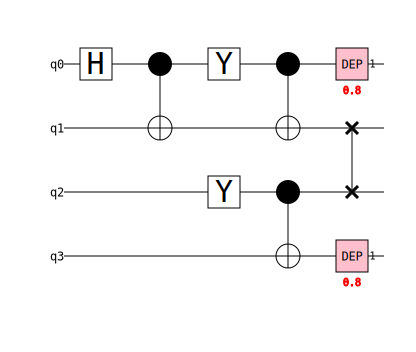

In [8]:
"""
Parse a stim circuit and add single qubit depolarizing errors for each no-op in the circuit. 
(Excluding state preperation)
""" 
def add_identity_error(circuit, prob):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for opidx, op in enumerate(circuit):
        new_circuit.append(op)
        if opidx > 2:
            qubits = set(range(num_qubits))
            active_qubits = set([x.value for x in op.targets_copy()])
            noop_qubits = list(qubits.difference(active_qubits))
            if len(noop_qubits) > 0: new_circuit.append("DEPOLARIZE1", noop_qubits, prob)
    return new_circuit


test = stim.Circuit()
test.append("H", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test_with_error = add_identity_error(test, 0.8)
print(test_with_error)
test_with_error.diagram(type="timeline-svg")

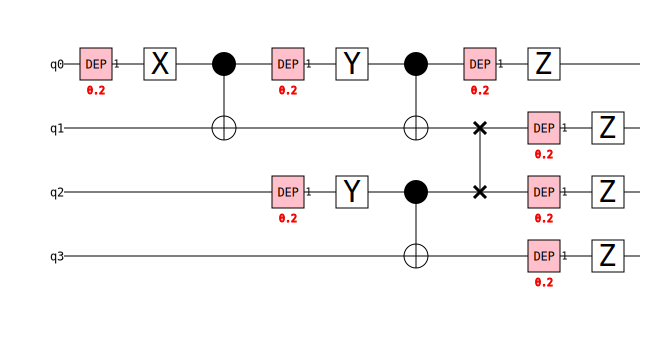

In [9]:
"Parse a stim circuit and add single qubit depolarizing errors BEFORE each single qubit gate"
def add_1gate_error(circuit, prob, gates_with_error=["X", "Y", "Z"]):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for op in circuit:
        strop = op.__str__() # op to string
        gate_arg = strop.split()[0] # Filter out first argument
        if gate_arg in set(gates_with_error):
            error_qubits = strop.split()[1:] # list of strings
            error_qubits = [eval(i) for i in error_qubits] # list of ints
            if len(error_qubits) > 0: new_circuit.append("DEPOLARIZE1", error_qubits, prob)
        new_circuit.append(op)
    return new_circuit


test = stim.Circuit()
test.append("X", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test.append("Z",[0,1,2,3])
test_with_error = add_1gate_error(test, 0.2)
# print(test_with_error)
test_with_error.diagram(type="timeline-svg")

In [10]:
def add_measurement_error(measurements, prob):
    new_measurements = []
    error_locations = []
    for idx, m in enumerate(measurements):
        if random() <= prob:
            new_measurements.append(not m)
            error_locations.append(idx)
        else:
            new_measurements.append(m)
    return new_measurements, error_locations

print(add_measurement_error([True, False, True], 1.0))
print(add_measurement_error([True, False, True], 0.0))
print(add_measurement_error([True, False, True], 0.5))

([False, True, False], [0, 1, 2])
([True, False, True], [])
([True, True, True], [1])


### Statevector methods

In [11]:
"""
Extracts the statevector corresponding to the output pair and calculate the fidelity with respect to phi plus

This function runs under the assumption that the Bell pair is located at the last 2 qubits of the circuit.
"""
def bell_fidelity(simulator):
    q = simulator.num_qubits
    stabs = simulator.canonical_stabilizers()
    bell_stabs = [] #stabilizers for reduced state (presumably a bell pair)
    for s in [stabs[-2], stabs[-1]]:
        stab_string = s.__str__()
        phase = stab_string[0] 
        qubits = stab_string[q-1] + stab_string[q]
        bell_stabs.append(stim.PauliString(phase+qubits))
    bell_simulator = stim.TableauSimulator()
    bell_simulator.set_state_from_stabilizers(bell_stabs)
    ideal_state_vector = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]
    return np.inner(bell_simulator.state_vector(), ideal_state_vector)

### Main purification protocol

+Z_________________
+_Z________________
+__Z_______________
+___Z______________
+____Z_____________
+_____Z____________
+______XX________XX
+______Z________Z_Z
+_______Z_______Z_Z
+________Z_________
+_________Z________
+__________Z_______
+___________Z______
+____________Z_____
+_____________Z____
+______________XXXX
+______________ZZ__
+________________ZZ
Purification measurements: [True, True, True, True, True, False, False, True, False, True, True, True]
successful purifications: []
Purification successful? :: False
Output pair fidelity: 0


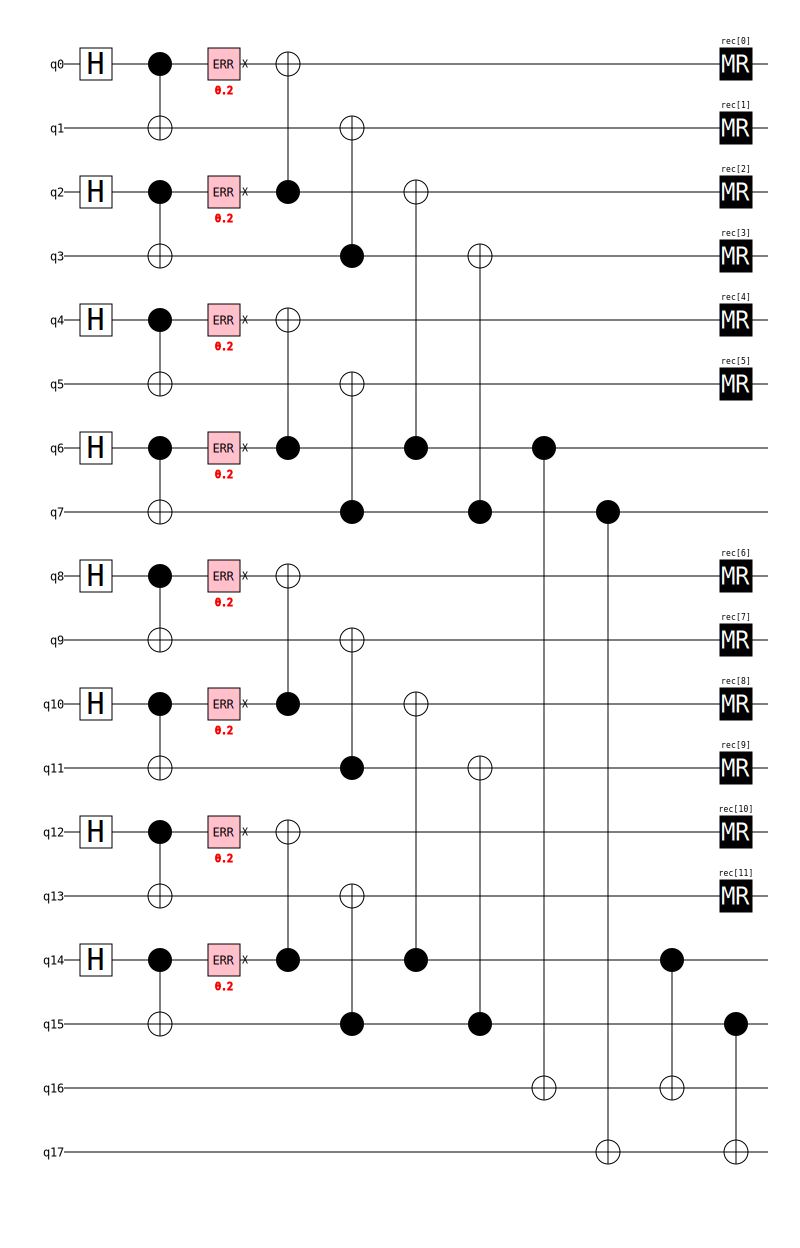

In [232]:
"""
Simulates a multi_round purification circuit with errors.

Returns a circuit level description, a True/False on if the protocol was successful and the corresponding Fidelity
(Defaults to 0 if purification was unsuccesful)
"""
def multi_round_purification(num_rounds=1, num_purifiers=2, F_err=0.0, ierr=0.0, cnot_err=0.0, single_gate_err=0.0, measurement_err=0.0, bell_err_type="DEPOLARIZE1", debug=False):
    
    num_qubits = num_purifiers * 2**(num_rounds + 1)
    circuit = initialize_pairs(num_qubits, F_err, bell_err_type)
    # Iterate here: Calculate the pair list for each level, remove ints from list, add them to another list for measurements
    pairs = list(range(num_qubits))
    for i in range(num_rounds):
        add_bilateral_cnots(circuit, pairs, cnot_err)
        pairs = [i for pair in zip(pairs[2::4], pairs[3::4]) for i in pair]
    # Add conditional teleportation
    add_conditional_teleportation(circuit, num_purifiers, cnot_err)
    # Add identity errors:
    if ierr != 0: circuit = add_identity_error(circuit, ierr)
    # Measure everything but the last two qubits of each purifier:
    add_measurement_resets(circuit, num_purifiers)
    simulator = stim.TableauSimulator()
    simulator.do(circuit)
    if debug==True:
        for x in simulator.canonical_stabilizers(): print(x)
    purifier_successes = which_purifications_succeeded(simulator, num_purifiers, debug=debug)
    if len(purifier_successes) == 0:
        return circuit, False, 0
    
    ### PHASE 2: ### teleportation measurement with correction:
    # generate_correction_circuit(circuit, purifier_successes)
    teleport_with_correction(circuit, simulator, num_purifiers, purifier_successes, single_gate_err, debug=debug)
    F = bell_fidelity(simulator)
    if debug == True:
        print(f"Canonical stabilizers:")
        for x in simulator.canonical_stabilizers():
            print(x)
    return circuit, True, F

circuit, outcome, F = multi_round_purification(num_rounds=2, num_purifiers=2, F_err=0.2, debug=True, ierr = 0.0, cnot_err=0.0, single_gate_err=0.0, bell_err_type="X_ERROR")
print(f"Purification successful? :: {outcome}")
print(f"Output pair fidelity: {F}")
circuit.diagram(type="timeline-svg")

### Visualisation:

In [379]:
# I want to specify a particular error type, and then increment over that error, leaving everything else error_free.
class ErrorProbs:
    def __init__(self, F_err=0., ierr=0., cnot_err=0., single_gate_err=0., measurement_err=0., bell_err_type="DEPOLARIZE1"):
        valid_error_types = ["DEPOLARIZE1", "X_ERROR", "Y_ERROR", "Z_ERROR"]
        if bell_err_type not in valid_error_types: raise Exception(f"Unsupported Bell error type. Please pick from {bell_err_type}")
        self.F_err = F_err
        self.ierr = ierr
        self.cnot_err = cnot_err
        self.single_gate_err = single_gate_err
        self.measurement_err = measurement_err
        self.bell_err_type = bell_err_type
    
    def __str__(self):
        return f"""F_err: {self.F_err}
ierr: {self.ierr}
cnot_err: {self.cnot_err}
single_gate_err: {self.single_gate_err}
measurement_err: {self.measurement_err}
bell_err_type: {self.bell_err_type}
"""

In [366]:
def average_pair_fidelity(num_trials, num_rounds, num_purifiers, error_probs, quiet=False):
    ave_fidelity = 0
    num_misses = 0
    for i in range(num_trials):
        if quiet == False and i % 100 == 0: print(f"Running trial {i}")
        circuit, status, F = multi_round_purification(num_rounds=num_rounds,
                                                      num_purifiers=num_purifiers, 
                                                      F_err = error_probs.F_err, 
                                                      ierr = error_probs.ierr,
                                                      cnot_err = error_probs.cnot_err,
                                                      single_gate_err = error_probs.single_gate_err, 
                                                      measurement_err = error_probs.measurement_err, 
                                                      bell_err_type = error_probs.bell_err_type,
                                                      debug=False)
        if status == False:
            num_misses += 1
        else:
            ave_fidelity += F
    ave_fidelity = ave_fidelity / (num_trials - num_misses)
    return ave_fidelity

In [413]:
# Test average_pair_fidelity
F = 0.9
F_err = 1-F
err1 = ErrorProbs(F_err=F_err, bell_err_type="DEPOLARIZE1")
average_pair_fidelity(num_trials = 1000, num_rounds=2, num_purifiers=2, error_probs=err1, quiet=False)
# Hmm... Fidelity seems to be getting worse, not better... 
# Maybe I'm not selecting measurements correctly?
# Working hypothesis: Measurement resets don't contribute to measurement record?
# Could it be that the z error is just really poisonous for multiple rounds? It could be that these errors build up.

Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Running trial 500
Running trial 600
Running trial 700
Running trial 800
Running trial 900


(0.8755229975683582+0j)

[True, False]


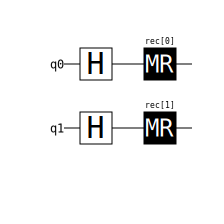

In [323]:
c = stim.Circuit()
c.append_operation("H", [0,1])
c.append_operation("MR", [0,1])
s = stim.TableauSimulator()
s.do(c)
print(s.current_measurement_record())
c.diagram(type="timeline-svg")